In [1]:
library(SingleCellExperiment)  # way to store single cell data
BiocManager::install("destiny")
library(destiny)  # diffusion maps and diffusion pseudotime
BiocManager::install("scater")
library(scater)  # related SingleCellExperiment package
if (!require("BiocManager", quietly = TRUE))
  install.packages("BiocManager")
BiocManager::install("clusterExperiment")
library(clusterExperiment)
install.packages("gam")
library(gam)
library(corrplot)
library(ggplot2)
library(ggthemes)
library(ggbeeswarm)
library(dplyr)
library(cowplot)
library(RColorBrewer)
library(knitr)

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges

In [5]:
# Set folder location for saving output files. This is also the same location as input data.
mydir <- "/home/claire/Downloads/trajectory"
# Objects to save.
Rda.destiny.path <- paste0(mydir, "trajectory_destiny.Rda")
Rda.slingshot.path <- paste0(mydir, "trajectory_slingshot.Rda")
set.seed(1)  # set a seed for your random number generator to get reproducible results 
opts_chunk$set(fig.align = "center")
# Read in single cell data downloaded from here: https://github.com/hemberg-lab/nrg-paper-figures/blob/master/deng-reads.rds
path.deng <- paste0(mydir, "/deng-reads.rds")
deng_SCE <- readRDS(path.deng)

In [3]:
# What class is the deng_SCE object, and how is it organized?
class(deng_SCE)
structure(deng_SCE)
# How many mouse cells are at each stage?
table(deng_SCE$cell_type1)
table(deng_SCE$cell_type2)
# Re-order the levels of the factor storing the cell developmental stage.
deng_SCE$cell_type2 <- factor(deng_SCE$cell_type2,
                              levels = c("zy", "early2cell", "mid2cell", "late2cell", 
                                         "4cell", "8cell", "16cell", "earlyblast",
                                         "midblast", "lateblast"))

[1] "SingleCellExperiment"
attr(,"package")
[1] "SingleCellExperiment"

class: SingleCellExperiment 
dim: 22431 268 
metadata(0):
assays(2): counts logcounts
rownames(22431): Hvcn1 Gbp7 ... Sox5 Alg11
rowData names(10): feature_symbol is_feature_control ... total_counts
  log10_total_counts
colnames(268): 16cell 16cell.1 ... zy.2 zy.3
colData names(30): cell_type2 cell_type1 ... pct_counts_ERCC
  is_cell_control
reducedDimNames(1): PCA
mainExpName: NULL
altExpNames(0):


16cell  2cell  4cell  8cell  blast zygote 
    50     22     14     37    133     12 


        zy early2cell   mid2cell  late2cell      4cell      8cell     16cell 
         4          8         12         10         14         37         50 
earlyblast   midblast  lateblast 
        43         60         30 

In [10]:
library(pcaMethods)
library(pheatmap)
install.packages("mclust")
library(mclust)
class(deng_SCE)
deng_SCE <- runPCA(deng_SCE, ncomponents = 50)
pca <- reducedDim(deng_SCE, "PCA")
head(pca)
dim(pca)

Installing package into ‘/home/claire/R/x86_64-pc-linux-gnu-library/4.2’
(as ‘lib’ is unspecified)



[1] "SingleCellExperiment"
attr(,"package")
[1] "SingleCellExperiment"

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
16cell,24.79868,-62.20826,8.035201,-2.07391816,2.1297390,14.0930954,2.4645020,1.6350660,-7.202260,-9.862212,⋯,-3.559391,-4.7781174,7.92280920,-8.558202,7.058962,-3.058208,-0.5723866,4.674956,2.936258,3.5978317
16cell.1,28.77121,-50.35974,13.607012,0.08664449,0.9454185,3.5987880,2.1726663,-3.3481641,-8.967394,-6.664942,⋯,3.570104,2.3279923,-5.60067539,8.717056,-6.480960,-8.554813,-13.1868736,3.397938,3.420235,-3.4895386
16cell.2,26.67901,-61.03875,7.239352,-6.60967794,-1.0775002,11.8876579,-7.9007309,0.3368756,-6.032645,-5.295515,⋯,-2.266017,0.8150665,-5.25328812,-5.803788,2.726822,-1.241769,7.4824415,-4.088461,-4.446014,-0.2326760
16cell.3,29.01151,-56.03620,6.433057,2.85332708,-4.2885083,-0.1488504,-4.3727592,-1.1582470,-1.520145,8.789699,⋯,3.123082,1.0916370,0.05135523,-2.181424,2.404780,-8.691230,8.9700016,-3.713540,5.179604,9.7144236
16cell.4,26.38026,-58.09265,4.671850,7.99519397,9.8077416,2.0570042,-0.6031572,-3.6743278,-5.793753,-10.823787,⋯,-4.223035,-1.4763577,-1.55019720,4.946841,0.520753,3.068227,10.7801148,5.167658,1.077789,3.0529018
16cell.5,24.90566,-60.77897,5.632497,-3.80156587,9.8835527,11.9028394,-4.3269009,3.8968881,-11.805221,-9.798854,⋯,-11.186021,-4.5635674,9.98211745,-8.759947,-3.727758,9.064882,-1.7524456,-3.306621,-5.019027,0.9275007


[1] 268  50

In [8]:
# Add PCA data (first two PCs) to the deng_SCE object.
deng_SCE$PC1 <- pca[, 1]
deng_SCE$PC2 <- pca[, 2]
head(colData(deng_SCE))

DataFrame with 6 rows and 32 columns
         cell_type2  cell_type1 total_features log10_total_features
           <factor> <character>      <integer>            <numeric>
16cell       16cell      16cell           7882              3.89669
16cell.1     16cell      16cell           7671              3.88491
16cell.2     16cell      16cell           8012              3.90380
16cell.3     16cell      16cell           7980              3.90206
16cell.4     16cell      16cell           8179              3.91275
16cell.5     16cell      16cell           7291              3.86285
         total_counts log10_total_counts pct_counts_top_50_features
            <integer>          <numeric>                  <numeric>
16cell        8825980            6.94576                    16.1420
16cell.1      7714601            6.88731                    14.3400
16cell.2      8074971            6.90714                    16.2521
16cell.3      6334456            6.80171                    14.7442
16cell.4   

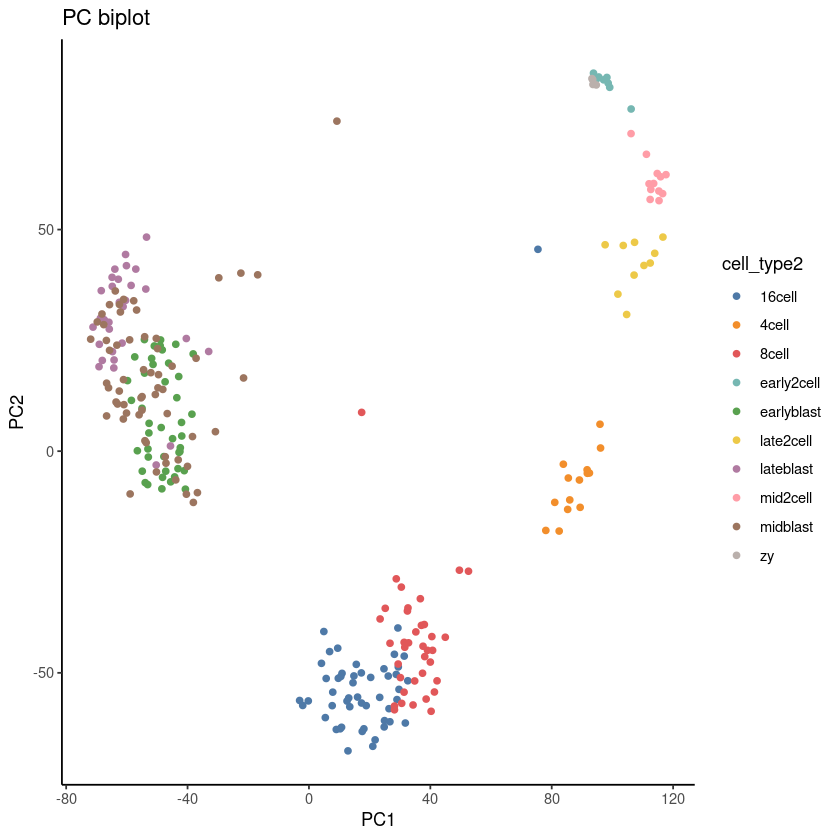

In [7]:
# Plot PC biplot with cells colored by cell_type2. 
# colData(deng_SCE) accesses the cell metadata DataFrame object for deng_SCE.
# Look at Figure 1A of the paper as a comparison to your PC biplot.
ggplot(as.data.frame(colData(deng_SCE)), aes(x = PC1, y = PC2, color = cell_type2)) + geom_quasirandom(groupOnX = FALSE) +
  scale_color_tableau() + theme_classic() +
  xlab("PC1") + ylab("PC2") + ggtitle("PC biplot")

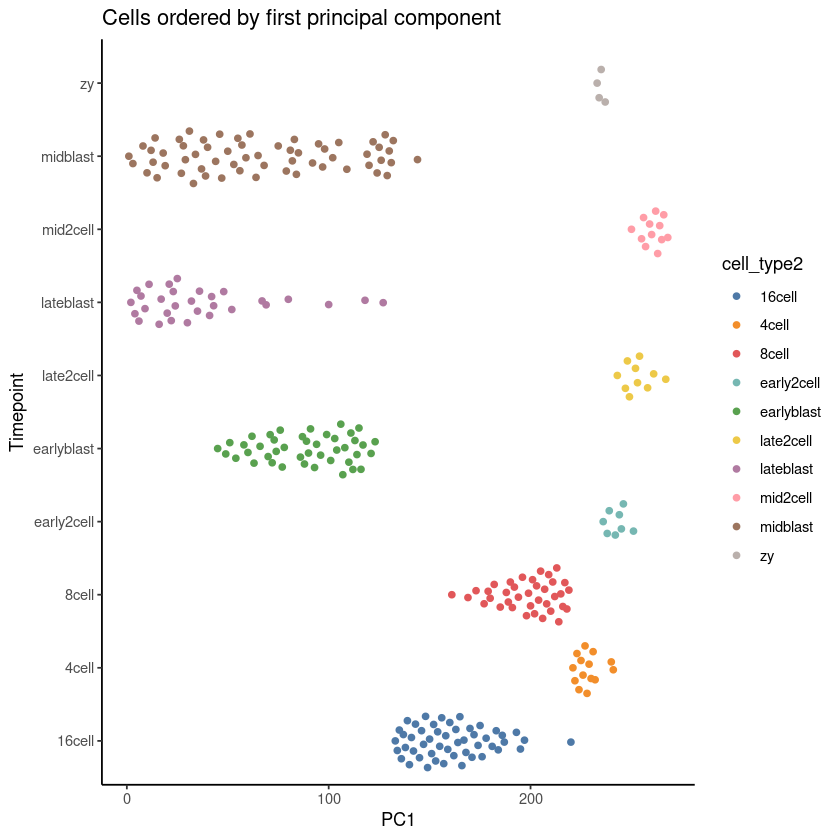

In [9]:
# PCA is a simple approach and can be good to compare to more complex algorithms 
# designed to capture differentiation processes. As a simple measure of pseudotime 
# we can use the coordinates of PC1.
# Plot PC1 vs cell_type2. 
deng_SCE$pseudotime_PC1 <- rank(deng_SCE$PC1)  # rank cells by their PC1 score
ggplot(as.data.frame(colData(deng_SCE)), aes(x = pseudotime_PC1, y = cell_type2, 
                                             colour = cell_type2)) +
  geom_quasirandom(groupOnX = FALSE) +
  scale_color_tableau() + theme_classic() +
  xlab("PC1") + ylab("Timepoint") +
  ggtitle("Cells ordered by first principal component")

#save:
#ggsave(paste0(mydir, "/pseudotime_PC1.png"))


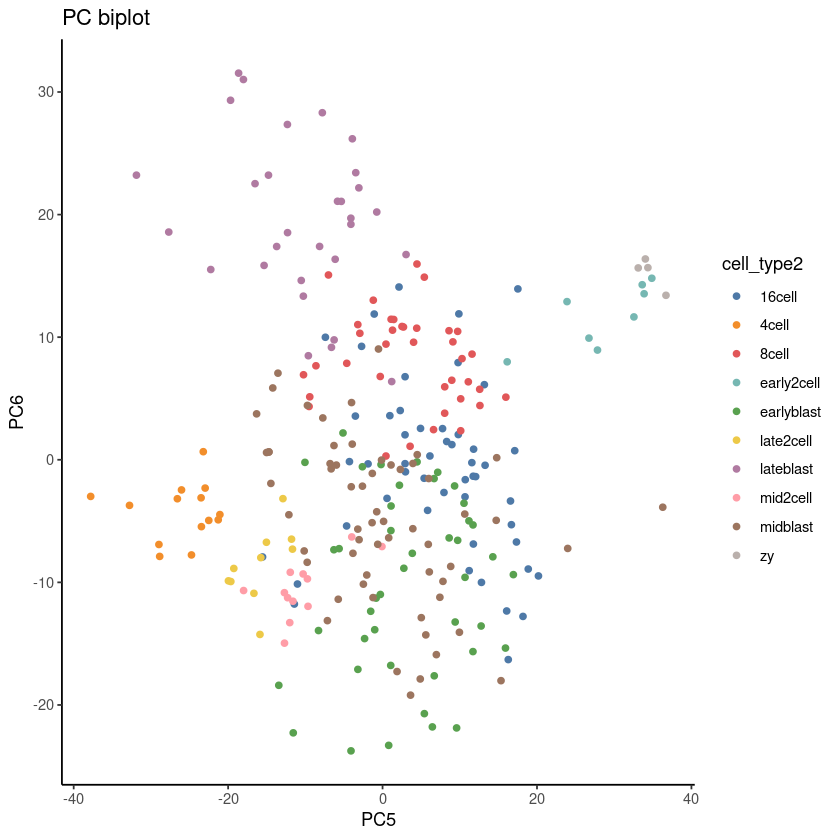

In [11]:
# Try separating the cell types using other PCs. How does the separation look?
deng_SCE$PC5 <- pca[, 5]
deng_SCE$PC6 <- pca[, 6]
ggplot(as.data.frame(colData(deng_SCE)), aes(x = PC5, y = PC6, color = cell_type2)) + geom_quasirandom(groupOnX = FALSE) +
  scale_color_tableau() + theme_classic() +
  xlab("PC5") + ylab("PC6") + ggtitle("PC biplot")

In [12]:
#  Prepare a counts matrix with labeled rows and columns. 
deng <- logcounts(deng_SCE)# access log-transformed counts matrix
cellLabels <- deng_SCE$cell_type2
colnames(deng) <- cellLabels

# Make a diffusion map.
dm <- destiny::DiffusionMap(t(deng))

Warning message in destiny::DiffusionMap(t(deng)):
“You have 22431 genes. Consider passing e.g. n_pcs = 50 to speed up computation.”
Warning message:
“as(<dsCMatrix>, "dsTMatrix") is deprecated since Matrix 1.5-0; do as(., "TsparseMatrix") instead”


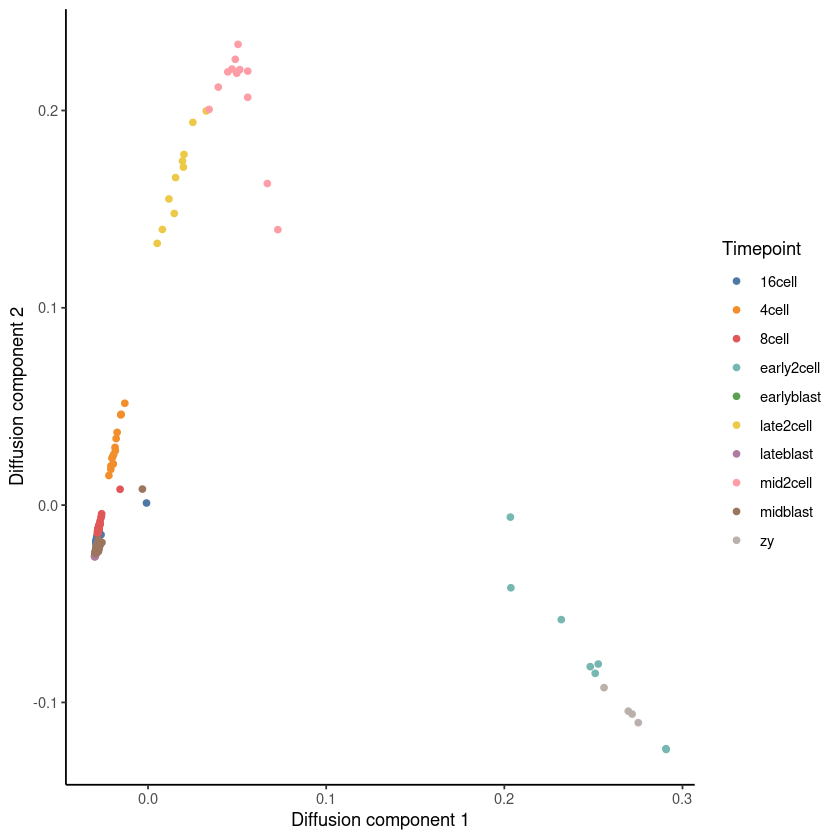

In [13]:
# Plot diffusion component 1 vs diffusion component 2 (DC1 vs DC2). 
tmp <- data.frame(DC1 = destiny::eigenvectors(dm)[, 1],
                  DC2 = destiny::eigenvectors(dm)[, 2],
                  Timepoint = cellLabels)
ggplot(tmp, aes(x = DC1, y = DC2, colour = Timepoint)) +
  geom_point() + scale_color_tableau() + 
  xlab("Diffusion component 1") + 
  ylab("Diffusion component 2") +
  theme_classic()

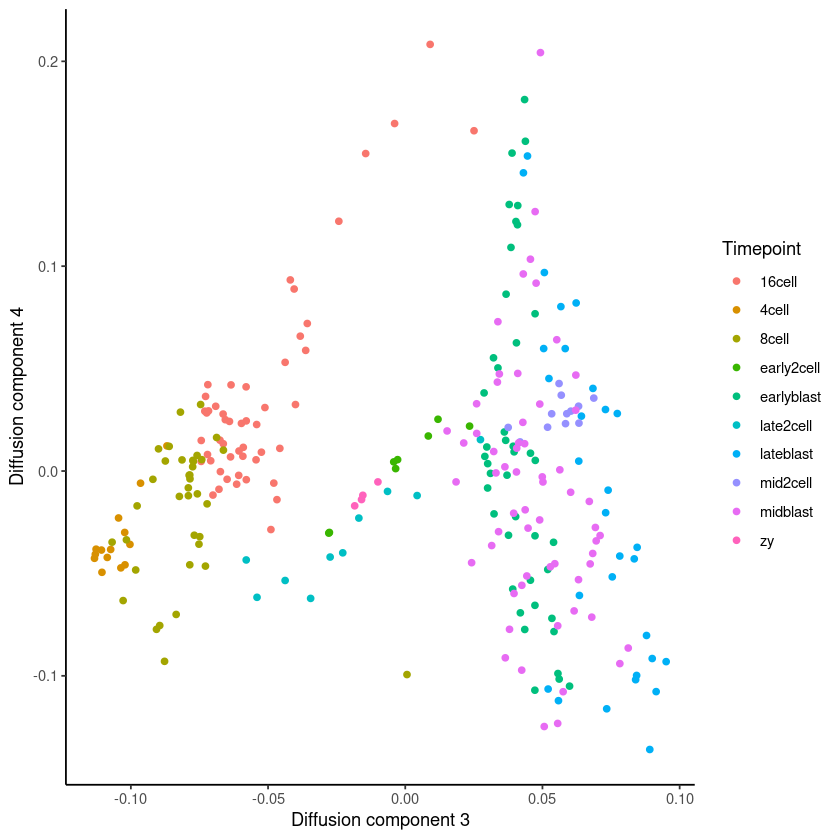

In [14]:
# Try plotting higher diffusion components against one another.
tmp <- data.frame(DC3 = destiny::eigenvectors(dm)[, 3],
                  DC4 = destiny::eigenvectors(dm)[, 4],
                  Timepoint = cellLabels)
ggplot(tmp, aes(x = DC3, y = DC4, colour = Timepoint)) +
  geom_point() + #scale_color_tableau() + 
  xlab("Diffusion component 3") + 
  ylab("Diffusion component 4") +
  theme_classic()

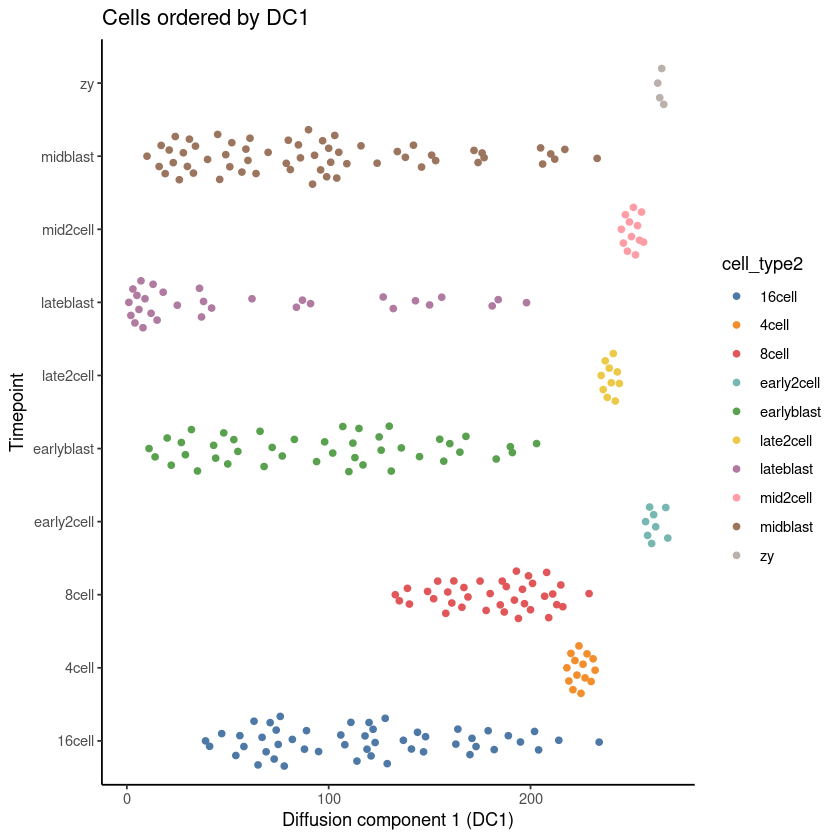

In [15]:
# Next, let us use the first diffusion component (DC1) as a measure of pseudotime.
# How does the separation by cell stage look?
deng_SCE$pseudotime_diffusionmap <- rank(destiny::eigenvectors(dm)[,1])    # rank cells by their dpt
ggplot(as.data.frame(colData(deng_SCE)), 
       aes(x = pseudotime_diffusionmap, 
           y = cell_type2, colour = cell_type2)) +
  geom_quasirandom(groupOnX = FALSE) +
  scale_color_tableau() + theme_classic() +
  xlab("Diffusion component 1 (DC1)") + ylab("Timepoint") +
  ggtitle("Cells ordered by DC1")

#ggsave(paste0(mydir, "/pseudotime_DC1.png"))


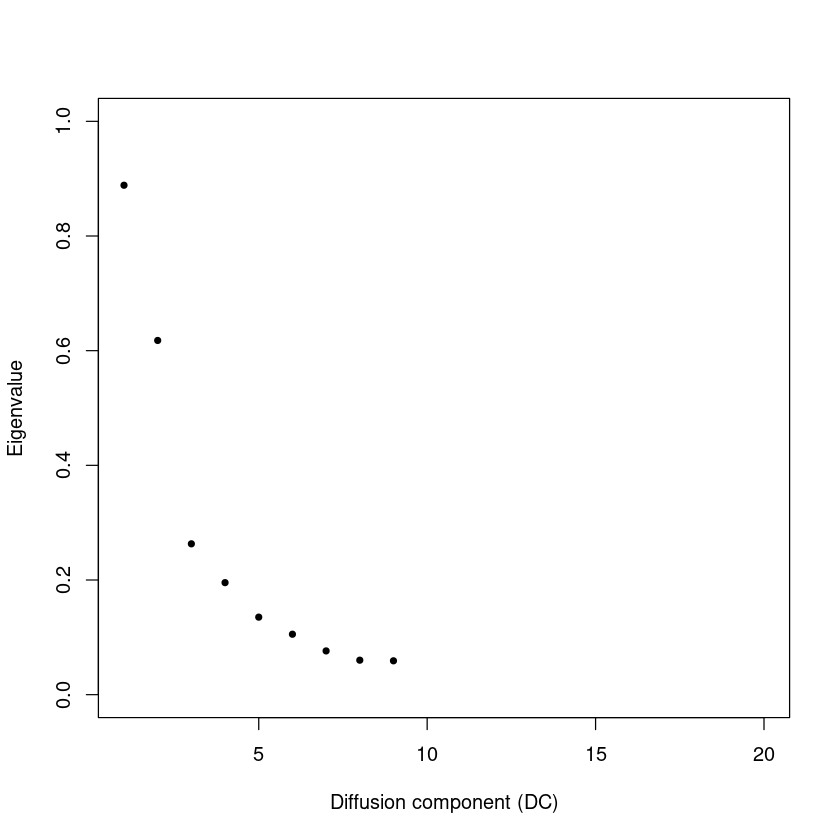

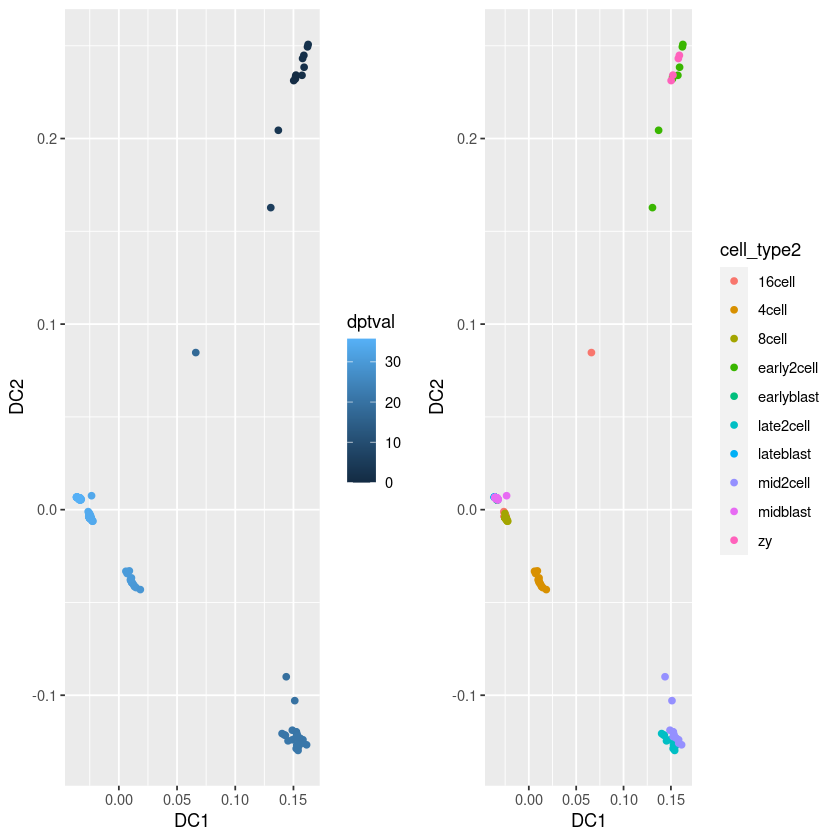

In [16]:
# Plot eigenvalues of diffusion distance matrix. How many diffusion components would you use?
# This is analagous to the PC elbow plot (scree plot) that we previously used to assess how 
# many PCs to use in downstream applications like clustering.
plot(destiny::eigenvalues(dm), ylim = 0:1, pch = 20, xlab = 'Diffusion component (DC)', ylab = 'Eigenvalue')
# What happens if you run the diffusion map on the PCs? Why would one do this?
rownames(pca) <- cellLabels
dm <- destiny::DiffusionMap(pca)

# Diffusion pseudotime calculation. 
# Set index or tip of pseudotime calculation to be a zygotic cell (cell 268). 
dpt <- destiny::DPT(dm, tips = 268)

# Plot DC1 vs DC2 and color the cells by their inferred diffusion pseudotime.
# We can accesss diffusion pseudotime via dpt$dpt.
df <- data.frame(DC1 = destiny::eigenvectors(dm)[, 1], DC2 = destiny::eigenvectors(dm)[, 2], 
                 dptval = dpt$dpt, cell_type2 = cellLabels)
p1 <- ggplot(df) + geom_point(aes(x = DC1, y = DC2, color = dptval))
p2 <- ggplot(df) + geom_point(aes(x = DC1, y = DC2, color = cell_type2))
p <- plot_grid(p1, p2)
p

#save_plot(paste0(mydir, "/dpt_celltype.png"), p, base_height = 5, base_aspect_ratio = 2)


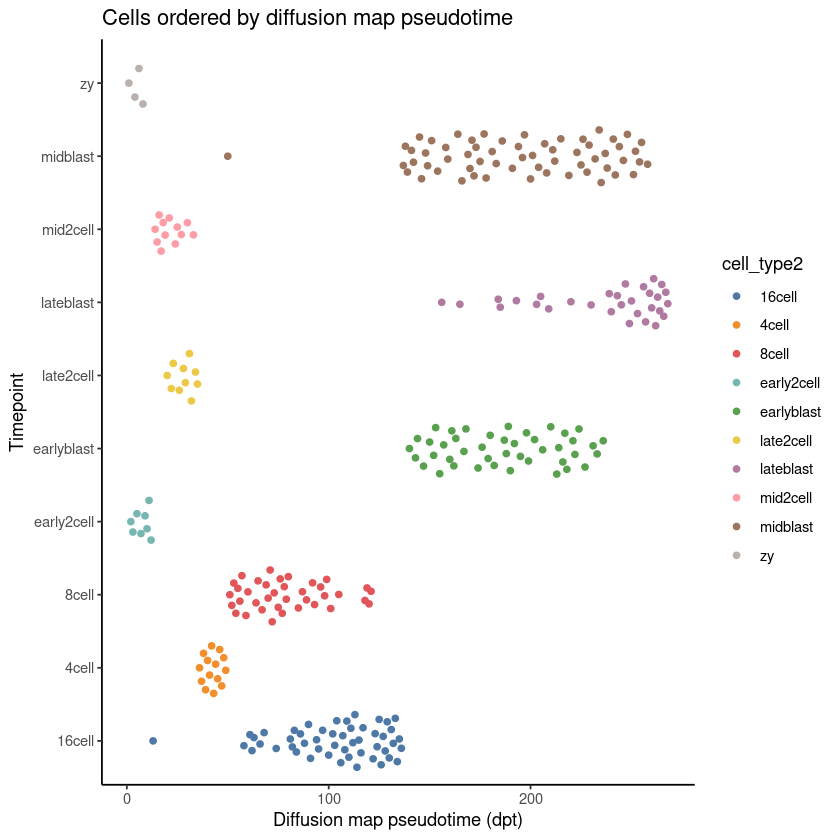

In [17]:
# Plot diffusion pseudotime vs timepoint. 
# Which separates the data better, DC1 or diffusion pseudotime?
deng_SCE$pseudotime_dpt <- rank(dpt$dpt) 
ggplot(as.data.frame(colData(deng_SCE)), 
       aes(x = pseudotime_dpt, 
           y = cell_type2, colour = cell_type2)) +
  geom_quasirandom(groupOnX = FALSE) +
  scale_color_tableau() + theme_classic() +
  xlab("Diffusion map pseudotime (dpt)") +
  ylab("Timepoint") +
  ggtitle("Cells ordered by diffusion map pseudotime")

#ggsave(paste0(mydir, "/pseudotime_dpt.png"))


# Save current progress.
#save(deng_SCE, file = Rda.destiny.path)
# To load the data, run the following command.
# load(Rda.destiny.path)

In [19]:
### SLINGSHOT #######################


BiocManager::install("slingshot")
library(slingshot)
library(Seurat)
sce <- slingshot(deng_SCE, reducedDim = 'PCA')  # no clusters


'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cloud.r-project.org


Bioconductor version 3.15 (BiocManager 1.30.19), R 4.2.1 (2022-06-23)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'slingshot'”
Installation paths not writeable, unable to update packages
  path: /usr/lib/R/library
  packages:
    boot, foreign, mgcv, nlme, rpart, survival
  path: /usr/local/lib/R/site-library
  packages:
    BiocManager, BiocVersion, brew, bslib, commonmark, cpp11, crayon, curl,
    data.table, desc, digest, dplyr, evaluate, farver, FNN, fontawesome,
    future, future.apply, generics, ggplot2, ggrepel, ggridges, gitcreds,
    globals, gtable, gtools, highr, htmltools, htmlwidgets, httpuv, ica,
    igraph, irlba, isoband, jsonlite, knitr, leiden, lifecycle, listenv,
    Matrix, matrixStats, parallelly, patchwork, pbapply, p

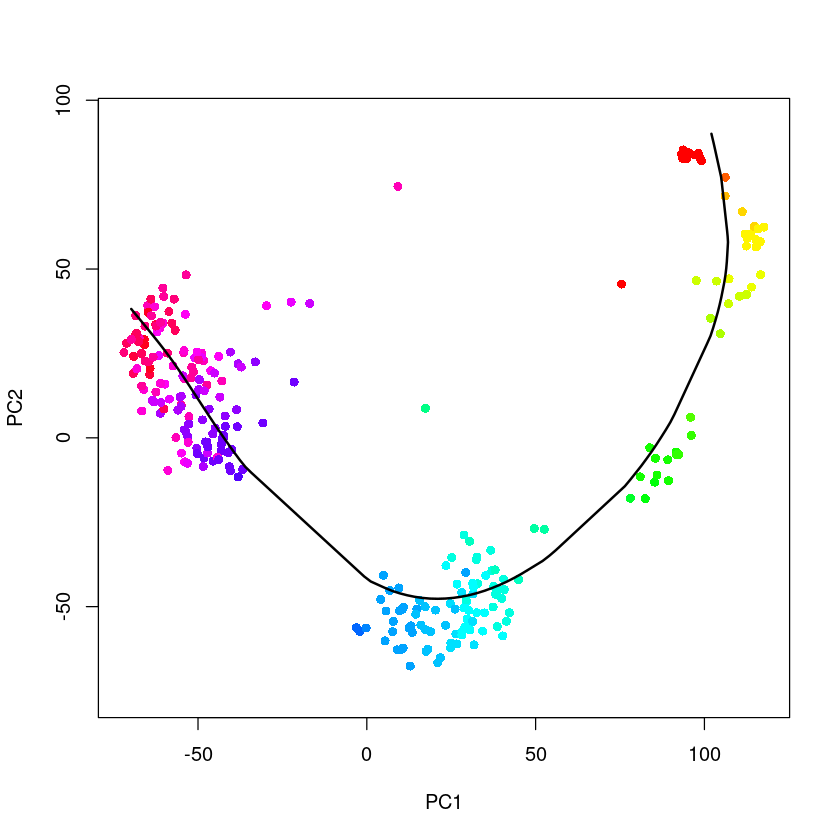

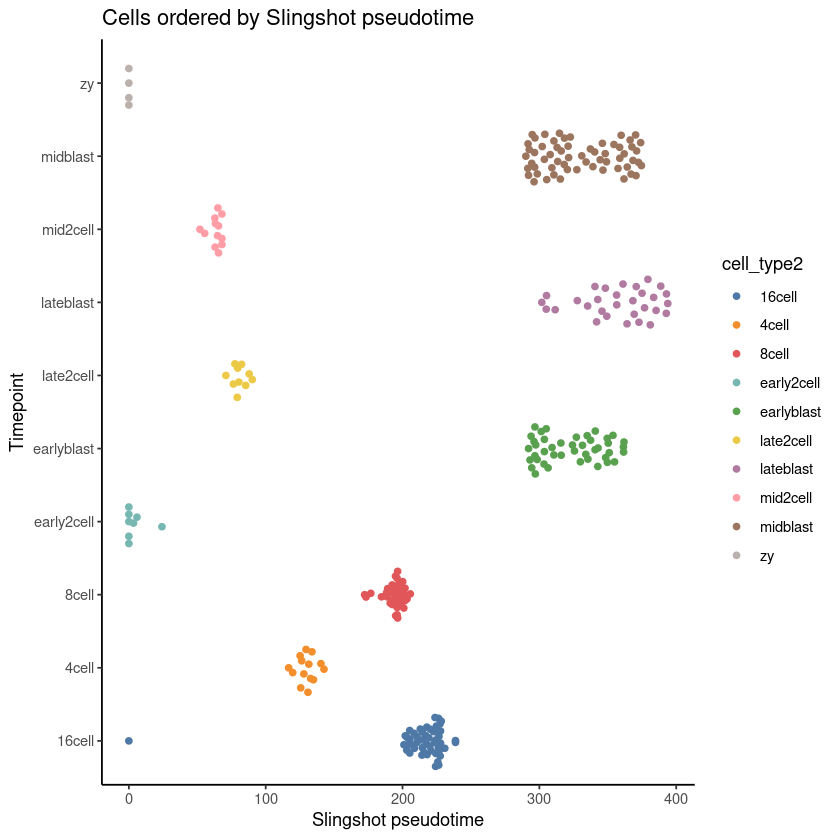

In [20]:

# Plot PC1 vs PC2 colored by Slingshot pseudotime.
colors <- rainbow(50, alpha = 1)
plot(reducedDims(sce)$PCA, col = colors[cut(sce$slingPseudotime_1,breaks=50)], pch=16, asp = 1)
lines(SlingshotDataSet(sce), lwd=2)

# Plot Slingshot pseudotime vs cell stage. 
ggplot(as.data.frame(colData(deng_SCE)), aes(x = sce$slingPseudotime_1, y = cell_type2, 
                                             colour = cell_type2)) +
  geom_quasirandom(groupOnX = FALSE) +
  scale_color_tableau() + theme_classic() +
  xlab("Slingshot pseudotime") + ylab("Timepoint") +
  ggtitle("Cells ordered by Slingshot pseudotime")

In [21]:
# Cluster cells using the Seurat workflow below.
gcdata <- CreateSeuratObject(counts = counts(deng_SCE), project = "slingshot")



gcdata <- NormalizeData(gcdata, normalization.method = "LogNormalize", scale.factor = 10000)
gcdata <- FindVariableFeatures(gcdata, selection.method = "vst", nfeatures = 2000)
gcdata <- ScaleData(object = gcdata, do.center = T, do.scale = F)

gcdata <- RunPCA(gcdata, features = VariableFeatures(gcdata), npcs = 40, ndims.print = 1:5, nfeatures.print = 5)

# Cluster the cells using the first twenty principal components.
gcdata <- FindNeighbors(gcdata, reduction = "pca", dims = 1:20, k.param = 20)

gcdata <- FindClusters(gcdata, resolution = 0.6, algorithm = 1, random.seed = 100)

# Add clustering information from Seurat to the deng_SCE object
deng_SCE$slingPseudotime_1 <- NULL  # remove old slingshot pseudotime data
colData(deng_SCE)$Seurat_clusters <- as.character(Idents(gcdata))  # go from factor to character
head(colData(deng_SCE))


Warning message:
“Feature names cannot have pipe characters ('|'), replacing with dashes ('-')”
Centering data matrix

PC_ 1 
Positive:  Actb, Fabp3, Psap, Akr1b8, Krt18 
Negative:  Zbed3, C86187, Klf17, Btg4, Ccdc6 
PC_ 2 
Positive:  Krt18, Id2, Akr1b8, BC053393, Fabp3 
Negative:  Gm11517, Alppl2, Obox6, Pdxk, Trim43b 
PC_ 3 
Positive:  Id2, Krt18, Tspan8, BC053393, Krt8 
Negative:  Gm11517, Alppl2, Ypel5, Pdxk, Fam46c 
PC_ 4 
Positive:  Alppl2, Dab2, Gm11517, Krt18, Tspan8 
Negative:  Upp1, Tdgf1, Spp1, Zfp57, Tat 
PC_ 5 
Positive:  Klf17, Ddx24, Bod1l, Tor1b, Gm1995 
Negative:  Alppl2, Gm4340, Gm11756, Gm8300, Gm5039 

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 268
Number of edges: 6814

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8064
Number of communities: 5
Elapsed time: 0 seconds


DataFrame with 6 rows and 38 columns
         cell_type2  cell_type1 total_features log10_total_features
           <factor> <character>      <integer>            <numeric>
16cell       16cell      16cell           7882              3.89669
16cell.1     16cell      16cell           7671              3.88491
16cell.2     16cell      16cell           8012              3.90380
16cell.3     16cell      16cell           7980              3.90206
16cell.4     16cell      16cell           8179              3.91275
16cell.5     16cell      16cell           7291              3.86285
         total_counts log10_total_counts pct_counts_top_50_features
            <integer>          <numeric>                  <numeric>
16cell        8825980            6.94576                    16.1420
16cell.1      7714601            6.88731                    14.3400
16cell.2      8074971            6.90714                    16.2521
16cell.3      6334456            6.80171                    14.7442
16cell.4   

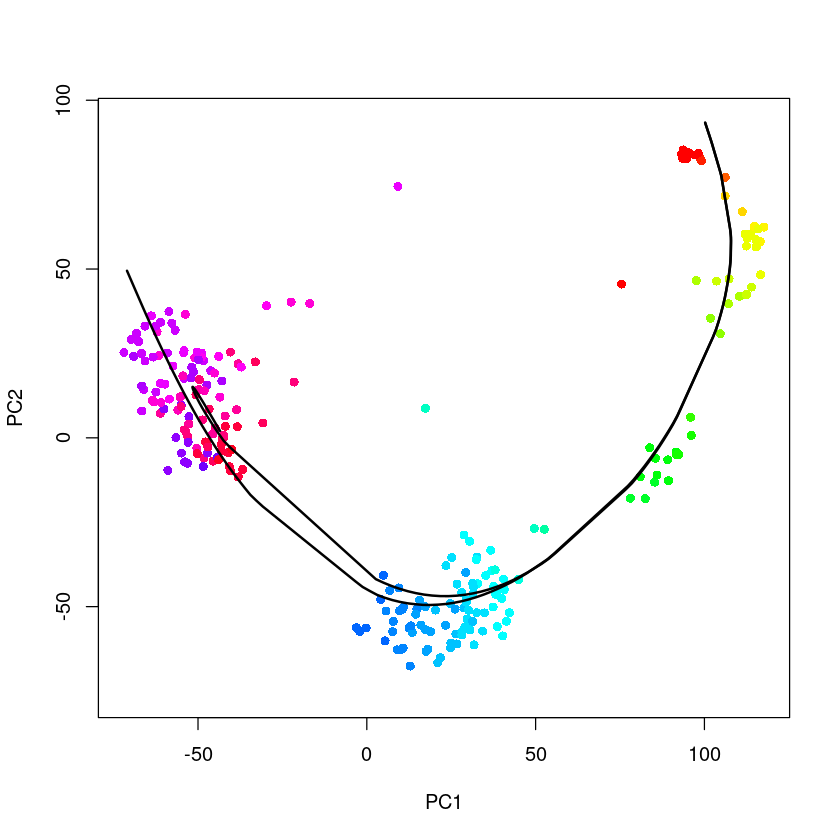

In [22]:
# Then run Slingshot using these cluster assignments.
deng_SCE <- slingshot(deng_SCE, clusterLabels = 'Seurat_clusters', reducedDim = 'PCA')

# Plot PC1 vs PC2 colored by Slingshot pseudotime.
colors <- rainbow(50, alpha = 1)
plot(reducedDims(deng_SCE)$PCA, col = colors[cut(deng_SCE$slingPseudotime_1,breaks=50)], pch=16, asp = 1)
lines(SlingshotDataSet(deng_SCE), lwd=2)

In [23]:
# Plot Slingshot pseudotime vs cell stage. 

ggplot(as.data.frame(colData(deng_SCE)), aes(x = deng_SCE$slingPseudotime_1, y = deng_SCE$cell_type2, 
                                             colour = deng_SCE$cell_type2)) +
  geom_quasirandom(groupOnX = FALSE) +
  scale_color_tableau() + theme_classic() +
  xlab("Slingshot pseudotime") + ylab("Timepoint") +
  ggtitle("Cells ordered by Slingshot pseudotime")

#"Error in as.vector(x) : no method for coercing this S4 class to a vector" issue with as.data.frame

#working around...
class(colData(deng_SCE))

dim(coldata)
class(coldata)
as.data.frame(coldata, row.names=NULL, optional=FALSE)
head(coldata)

BiocManager::install("S4Vectors")
library(S4Vectors)

as.data.frame(colData(deng_SCE))
S4Vectors::as.data.frame(colData(deng_SCE), optional = FALSE)

assays(deng_SCE)

deng_SCE


#still not working...
#moving on..

ERROR: Error in as.vector(x): no method for coercing this S4 class to a vector


In [24]:
# Only look at the 1,000 most variable genes when identifying temporally expressesd genes.
# Identify the variable genes by ranking all genes by their variance.
Y <- log2(counts(deng_SCE) + 1)
var1K <- names(sort(apply(Y, 1, var), decreasing = TRUE))[1:1000]
Y <- Y[var1K, ]  # only counts for variable genes

# Fit GAM for each gene using pseudotime as independent variable.
t <- deng_SCE$slingPseudotime_1
gam.pval <- apply(Y, 1, function(z){
  d <- data.frame(z=z, t=t)
  tmp <- gam(z ~ lo(t), data=d)
  p <- summary(tmp)[4][[1]][1,5]
  p
})

# Identify genes with the most significant time-dependent model fit.
topgenes <- names(sort(gam.pval, decreasing = FALSE))[1:100]  


In [25]:
# Prepare and plot a heatmap of the top genes that vary their expression over pseudotime.
require(clusterExperiment)
heatdata <- as.matrix(gcdata[['RNA']]@data[rownames(gcdata) %in% topgenes, order(t, na.last = NA)])
heatclus <- Idents(gcdata)[order(t, na.last = NA)]
png(paste0(mydir, "heatmap_time_genes.png"), width=10, height=10, units = "in", res=200)
# ce <- ClusterExperiment(heatdata, heatclus, transformation = log1p)
# clusterExperiment::plotHeatmap(ce, clusterSamplesData = "orderSamplesValue", visualizeData = 'transformed', cexRow = 1.5, fontsize = 15)
heatmap(log1p(heatdata), Colv = NA, ColSideColors = brewer.pal(9,"Set1")[heatclus])
dev.off()

png 
  2

In [26]:
# Prepare data frame with different pseudotime measures.
df_pseudotime <- as.data.frame(colData(deng_SCE)[, c("pseudotime_PC1", "pseudotime_dpt", "slingPseudotime_1")])
colnames(df_pseudotime) <- c("PC1", "diffusion", "slingshot")


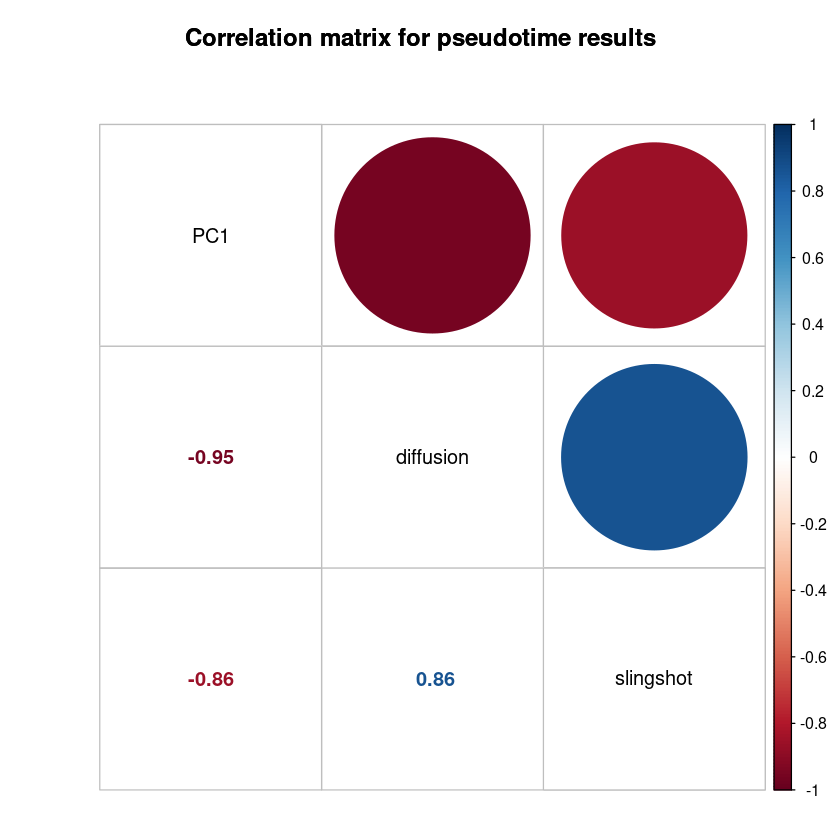

In [28]:
# Plot correlation between different pseudotime measures.
corrplot.mixed(cor(df_pseudotime, use = "na.or.complete"), 
               order = "hclust", tl.col = "black",
               main = "Correlation matrix for pseudotime results",
               mar = c(0, 0, 3.1, 0))

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


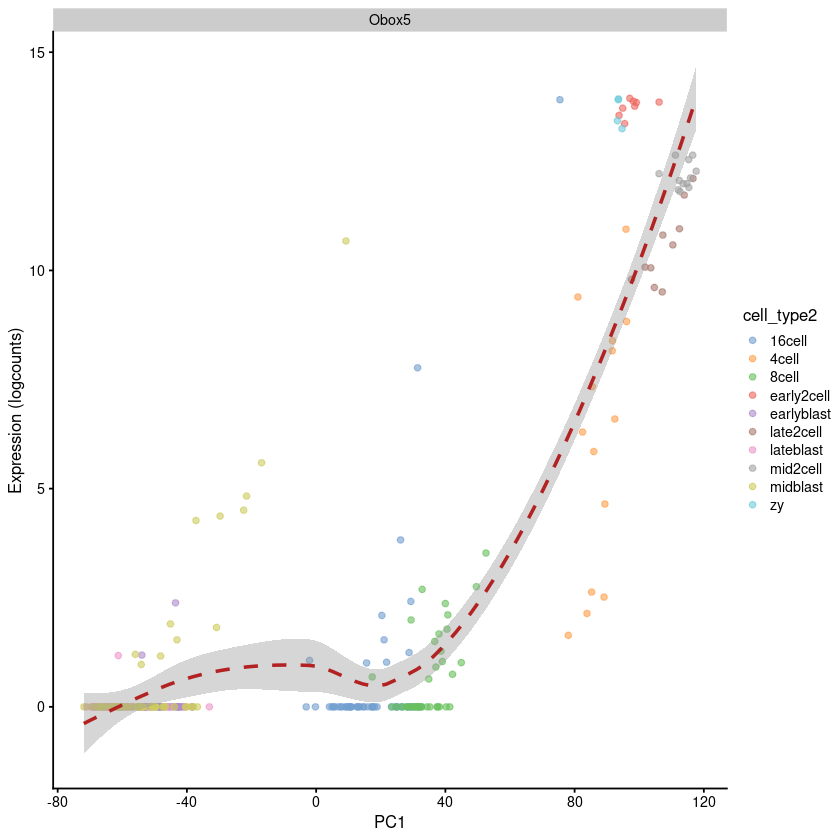

In [29]:
plotExpression(deng_SCE, "Obox5", x = "PC1", 
               colour_by = "cell_type2", show_violin = FALSE,
               show_smooth = TRUE)

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


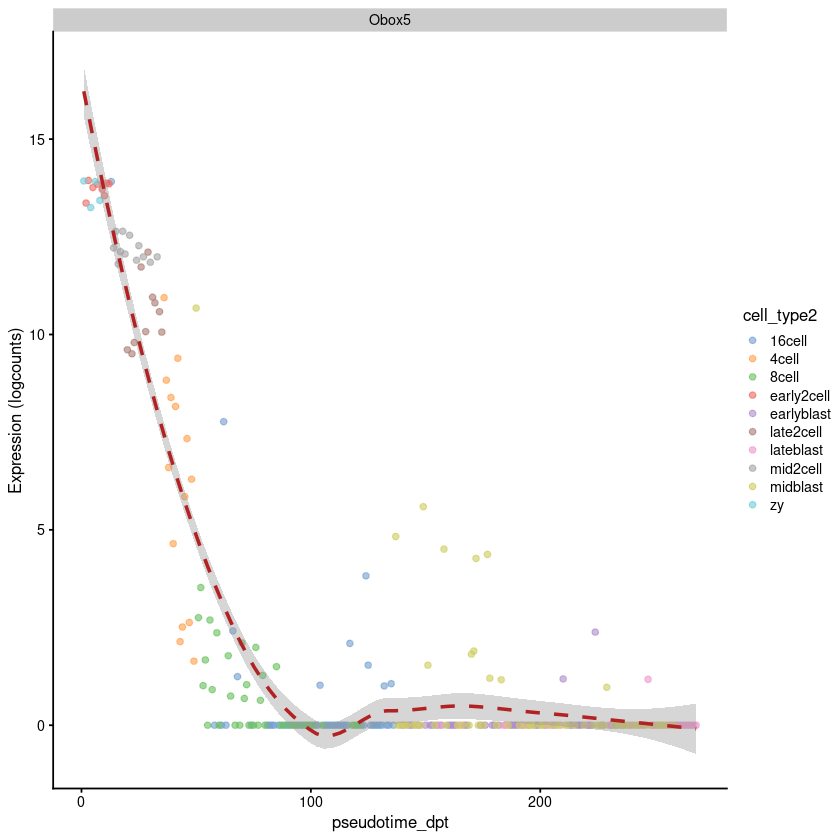

In [30]:
plotExpression(deng_SCE, "Obox5", x = "pseudotime_dpt", 
               colour_by = "cell_type2", show_violin = FALSE,
               show_smooth = TRUE)

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“Removed 22 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 22 rows containing missing values (`geom_point()`).”


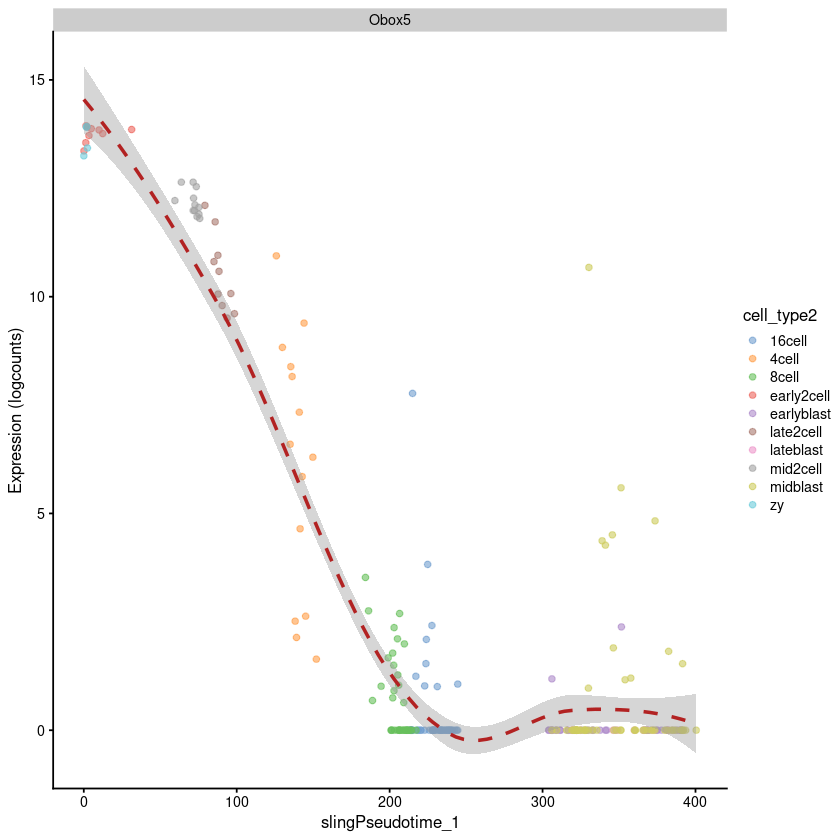

In [31]:
plotExpression(deng_SCE, "Obox5", x = "slingPseudotime_1", 
               colour_by = "cell_type2", show_violin = FALSE,
               show_smooth = TRUE)